<a href="https://colab.research.google.com/github/VirtueZhao/Dive_into_Deep_Learning/blob/main/4_3_Concise_Implementation_of_Multilayer_Precreptrons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import d2l
import torch
from torch import nn

In [5]:
from IPython import display

def accuracy(y_hat, y):

  if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    y_hat = y_hat.argmax(axis=1)

  cmp = y_hat.type(y.dtype) == y

  return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter):
  if isinstance(net, torch.nn.Module):
    net.eval()
  metric = Accumulator(2)
  for X, y in data_iter:
    metric.add(accuracy(net(X), y), y.numel())

  return metric[0] / metric[1]

class Accumulator:
  def __init__(self, n):
    self.data = [0.0] * n
  
  def add(self, *args):
    self.data = [a + float(b) for a,b in zip(self.data, args)]

  def reset(self):
    self.data = [0.0] * len(self.data)
  
  def __getitem__(self, idx):
    return self.data[idx]

def train_epoch_ch3(net, train_iter, loss, updater):
  if isinstance(net, torch.nn.Module):
    net.train()
  
  metric = Accumulator(3)
  for X, y in train_iter:
    y_hat = net(X)
    l = loss(y_hat, y)
    if isinstance(updater, torch.optim.Optimizer):
      updater.zero_grad()
      l.backward()
      updater.step()
      metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
    else:
      l.sum().backward()
      updater(X.shape[0])
      metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
  
  return metric[0] / metric[2], metric[1] / metric[2]

class Animator:
  def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None, 
        ylim=None, xscale='linear', yscale='linear', fmts=('-','m--','g-.','r:'),
        nrows=1, ncols=1, figsize=(3.5,2.5)):
    if legend is None:
      legend = []
    d2l.use_svg_display()
    self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
    if nrows * ncols == 1:
      self.axes = [self.axes,]
    self.config_axes = lambda: d2l.set_axes(
        self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    self.X, self.Y, self.fmts = None, None, fmts

  def add(self, x, y):
    if not hasattr(y, "__len__"):
      y = [y]
    n = len(y)
    if not hasattr(x, "__len__"):
      x = [x] * n
    if not self.X:
      self.X = [[] for _ in range(n)]
    if not self.Y:
      self.Y = [[] for _ in range(n)]
    for i, (a,b) in enumerate(zip(x,y)):
      if a is not None and b is not None:
        self.X[i].append(a)
        self.Y[i].append(b)
    self.axes[0].cla()
    for x, y, fmt in zip(self.X, self.Y, self.fmts):
      self.axes[0].plot(x,y,fmt)
    self.config_axes()
    display.display(self.fig)
    display.clear_output(wait=True)

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
  animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
              legend=['train loss', 'train acc', 'test acc'])
  for epoch in range(num_epochs):
    train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
    test_acc = evaluate_accuracy(net, test_iter)
    animator.add(epoch + 1, train_metrics + (test_acc,))
  train_loss, train_acc = train_metrics
  assert train_loss < 0.5, train_loss
  assert train_acc <= 1 and train_acc > 0.7, train_acc
  assert test_acc <= 1 and test_acc > 0.7, test_acc

def predict_ch3(net, test_iter, n=6):
  for X, y in test_iter:
    break
  trues = d2l.get_fashion_mnist_labels(y)
  preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
  titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
  d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

In [3]:
net = nn.Sequential(
          nn.Flatten(), 
          nn.Linear(784,256),
          nn.ReLU(),
          nn.Linear(256,10))

def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

In [4]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)

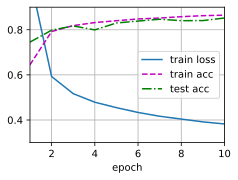

In [6]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)